In [1]:
! pip install numpy pandas datetime matplotlib seaborn scikit-learn yellowbrick

In [5]:
# Global Libraries

import pandas as pd
import numpy as np
import datetime
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

### Load Data

In [38]:
df = pd.read_csv("customer_df.csv", sep="\t")
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Dataset info:

#### Customer info:
- ID
- Year_Birth
- Education
- Marital_Status
- Income
- Kidhome
- Teenhome
- Dt_Customer
- Recency
- Complain

#### Products: 
Amount septn on differents productos in last 2 yearS 
- MntWines
- MntFruits
- MntMeatProducts
- MntFishProducts
- MntSweetProducts
- MntGoldProds

#### Place: 
- NumWebPurchase
- NumCatalogPurchases
- NumStorePurchase
- NumWebVisitsMonth

#### Promotion:
- NumDealsPurchase
- AcceptedCmp1
- AcceptedCmp2
- AcceptedCmp3
- AcceptedCmp4
- AcceptedCmp5
- Response

#### Data Cleaning

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [40]:
df = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


In [41]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])


dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [42]:
categorical_columns = df.select_dtypes(include=['object']).columns

# Mostrar las clases de cada variable categórica
for column in categorical_columns:
    unique_classes = df[column].unique()
    print(f"Variable: {column}")
    print(f"Clases: {unique_classes}")
    print("=" * 30)

Variable: Education
Clases: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Variable: Marital_Status
Clases: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [23]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [43]:

#Age of customer today 
df["Age"] = pd.Timestamp.now().year - df["Year_Birth"]

In [44]:
# Total Spending in Pareto Items

df['Spent'] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

In [45]:
# Mapping categorical variables before label encoding

# Simplifying living situation
df["Living_With"]= df["Marital_Status"].replace(
    {"Married":"Partner",
     "Together":"Partner",
     "Absurd":"Alone", 
     "Widow":"Alone", 
     "YOLO":"Alone", 
     "Divorced":"Alone",
     "Single":"Alone",}
)

# Simplifying numer of childrens
df["Children"] =df["Kidhome"]+ df["Teenhome"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)


# Counting total members in the household
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]


# Segmenting education leves in 3 groups
df["Education"]= df["Education"].replace(
    {"Basic":"Undergraduate",
     "2n Cycle":"Undergraduate",
     "Graduation":"Graduate",
     "Master":"Postgraduate",
     "PhD":"Postgraduate"}
)


#rename columns to simplify strings
df = df .rename(columns={
    "MntWines": "Wines",
    "MntFruits":"Fruits",
    "MntMeatProducts":"Meat",
    "MntFishProducts":"Fish",
    "MntSweetProducts":"Sweets",
    "MntGoldProds":"Gold"})

# Drop non necessary columns 

to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)



In [46]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Is_Parent,Family_Size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073105,0.064079,0.013538,0.009477,0.150271,54.179603,607.075361,0.947202,0.714350,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,0.749062,0.451825,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,5.000000,0.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,69.000000,0.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,396.500000,1.000000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,64.000000,1048.000000,1.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,130.000000,2525.000000,3.000000,1.000000,5.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

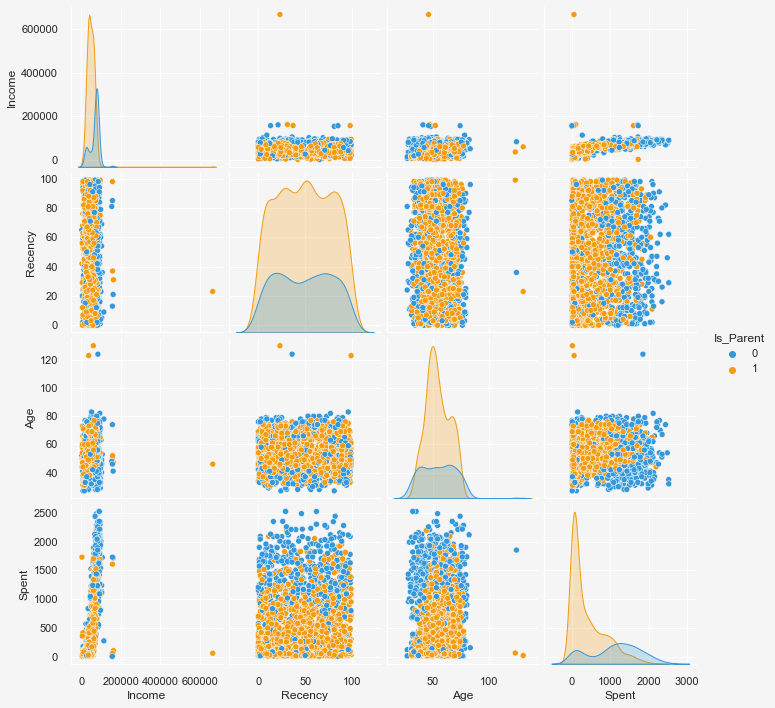

In [48]:
# To plot some selected features
# Setting up colors preferences
sns.set(rc={"axes.facecolor": "#F5F5F5", "figure.facecolor": "#F5F5F5"})
pallet = ["#3498db", "#e74c3c", "#95a5a6", "#2ecc71", "#9b59b6", "#f39c12"]
cmap = colors.ListedColormap(["#3498db", "#e74c3c", "#95a5a6", "#2ecc71", "#9b59b6", "#f39c12"])

# Plotting following features
To_Plot = ["Income", "Recency", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue="Is_Parent", palette=(["#3498db", "#f39c12"]))
# Taking hue
plt.show()

In [50]:
#Eliminar outliers:

#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))


The total number of data-points after removing the outliers are: 2212


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

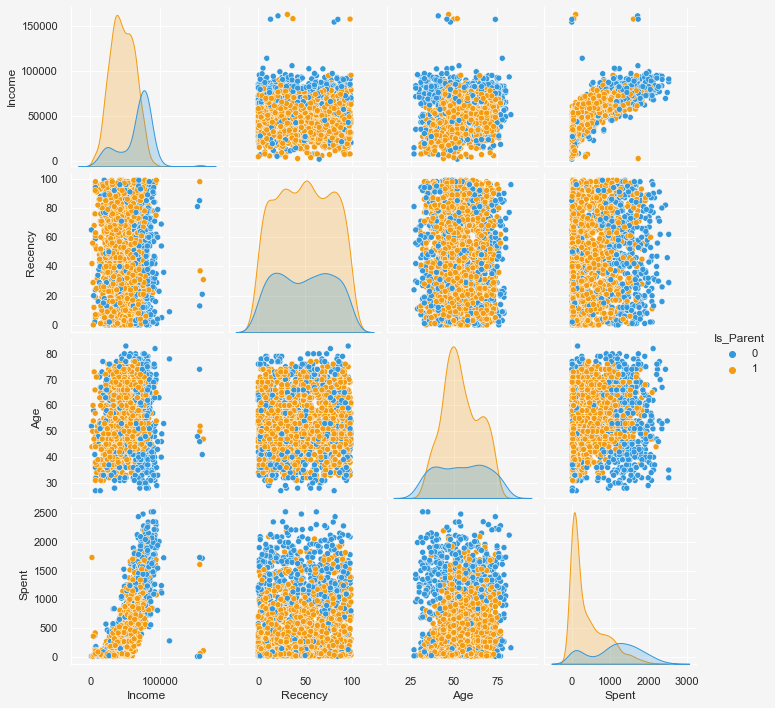

In [51]:
# To plot some selected features
# Setting up colors preferences
sns.set(rc={"axes.facecolor": "#F5F5F5", "figure.facecolor": "#F5F5F5"})
pallet = ["#3498db", "#e74c3c", "#95a5a6", "#2ecc71", "#9b59b6", "#f39c12"]
cmap = colors.ListedColormap(["#3498db", "#e74c3c", "#95a5a6", "#2ecc71", "#9b59b6", "#f39c12"])

# Plotting following features
To_Plot = ["Income", "Recency", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue="Is_Parent", palette=(["#3498db", "#f39c12"]))
# Taking hue
plt.show()

<AxesSubplot: >

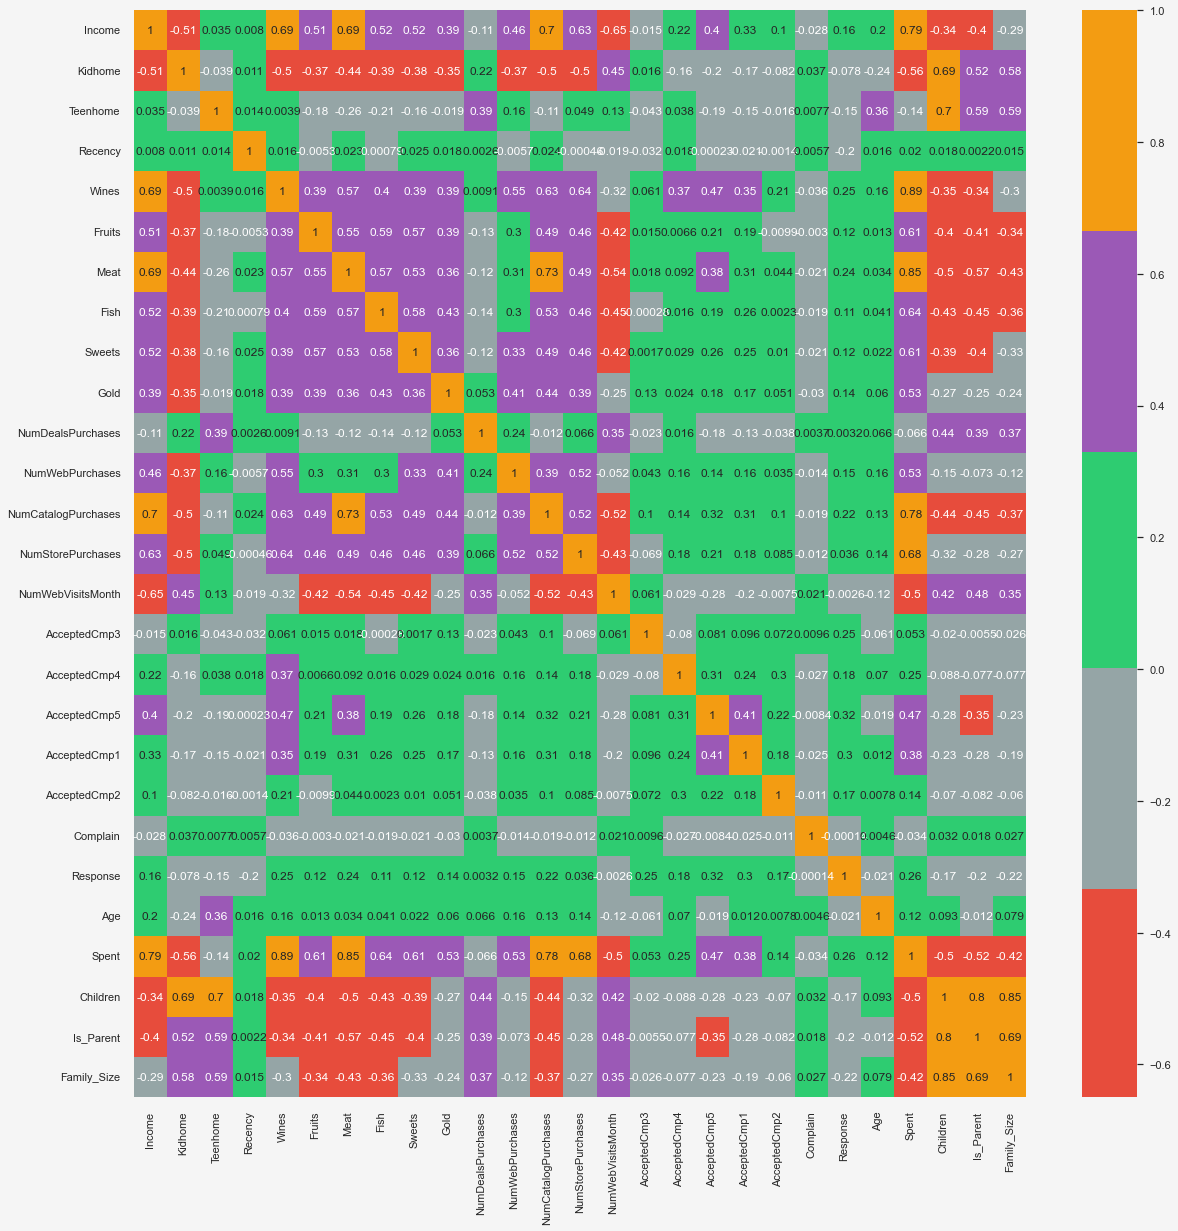

In [52]:
# See correlations

#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)


#### Data Preprocessing

* Label encoding for categorical variables
* Scaling the features using Standard Scaler
* Creating a subset dataframee for dimensionality reduction


In [53]:
#Get list of categorical variables

s = (df.dtypes == 'object')

object_cols = list(s[s].index)

LE = LabelEncoder()

for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)

In [60]:
# Scaled data 
from sklearn.preprocessing import StandardScaler

#Creating a copy of data
ds = df.copy()

# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']

ds = ds.drop(cols_del, axis=1)


#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )


print("All features are now scaled")

All features are now scaled


In [61]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Is_Parent,Family_Size
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.581139,-1.758359
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.632456,0.449070
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-1.581139,-0.654644
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.632456,0.449070
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.632456,0.449070


#### Dimensionality Reduction (PCA)

In [62]:
# Inicialiting PCA to reduce dimentions aka features to 3

pca = PCA(n_components = 3)

pca.fit(scaled_ds)

PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['col1', 'col2', 'col3']))

PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,4.497106e-17,2.877338,-5.940876,-2.552996,-0.776146,2.394880,7.411441
col2,2212.0,6.424437e-17,1.699736,-4.285495,-1.329381,-0.149696,1.244900,6.110746
col3,2212.0,1.445498e-17,1.153616,-2.943603,-0.891012,-0.140892,0.813277,3.963204


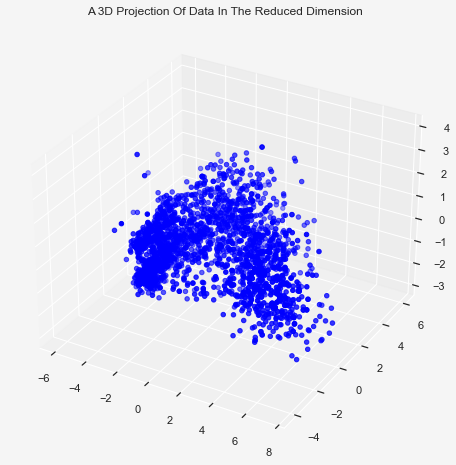

In [64]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

#### Clustering

Reducimos las features a 3 dimensiones. Realizaremos un clustering usando Agglomerative Clustering. Es una hierarchical clustering method. Este implica hacer mergin hacsta que el numero deseados de clusteres sea alcanzado.

* Elbow method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering
* Examining the clusters formed via Scatter plot

Elbow Methos to determine number of clusteres to be formed: 


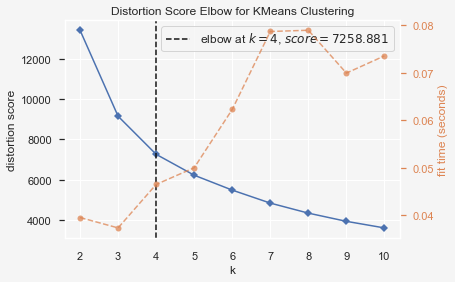

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
print('Elbow Methos to determine number of clusteres to be formed: ')

Elbow_M = KElbowVisualizer(KMeans(), k= 10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [68]:
#Initiating the Agglomerative Clustering model. 4 is the obtimal number of clusters for this data
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)

PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

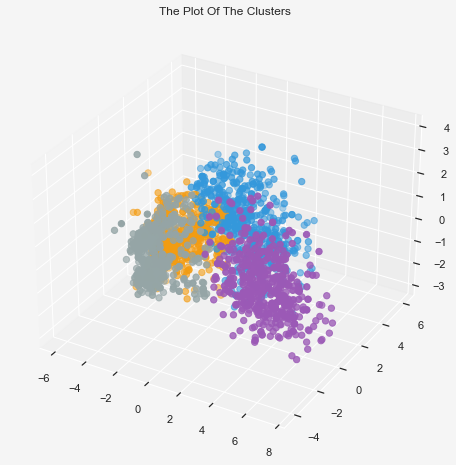

In [70]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

In [71]:
!pip install plotly

In [73]:
PCA_ds

,col1,col2,col3,Clusters
0,4.936903,-0.409354,1.156257,2
1,-2.835609,0.211789,0.722169,3
2,2.624988,-0.689811,-0.112257,2
3,-2.620430,-1.344159,-1.132719,1
4,-0.627505,0.286230,-1.249700,3
...,...,...,...,...
2207,2.314692,2.426724,-0.201849,0
2208,-3.056161,4.259680,-0.684912,3
2209,2.699508,-1.798850,1.378910,2
2210,1.518638,1.847320,-0.196353,0


In [77]:
import plotly.graph_objs as go
import plotly.express as px


# Create a scatter plot using plotly
#fig = px.scatter_3d(PCA_ds, x='col1', y='col2', z='col3', color='Clusters', symbol='Clusters', size_max=40, opacity=0.7, color_continuous_scale='Viridis')

# Update layout to add a title
#fig.update_layout(title="Interactive 3D Cluster Plot")

# Show the interactive plot
#fig.show()

#### Model Evaluation

Dado que es un modelo no supervisados, no tenemos etiquetas para evaluar o puntuar nuestro modelo.
Estudiaremos la naturaleza de los patrones en los clusteres formados.

Para esto realizaremos un EDA y así explorar conclusiones.

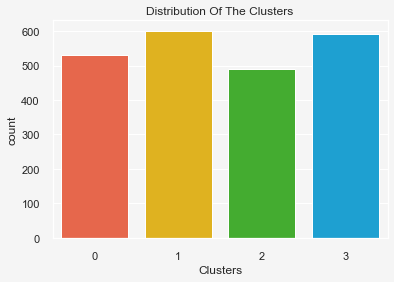

In [91]:
# Distribución de los clusteres 

#Plotting countplot of clusters
pallets =  ["#FF5733", "#FFC300", "#36C11B", "#00AEEF"]
pl = sns.countplot(x=df["Clusters"], palette= pallets)
pl.set_title("Distribution Of The Clusters")
plt.show()

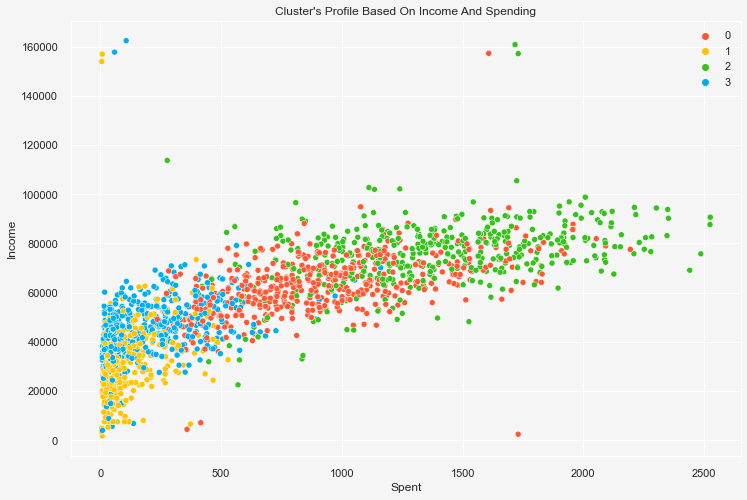

In [93]:
plt.figure(figsize=(12, 8))
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pallets)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

##### Income vs spending plot shows the clusters pattern

* group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income
* group 3: high spending & low income

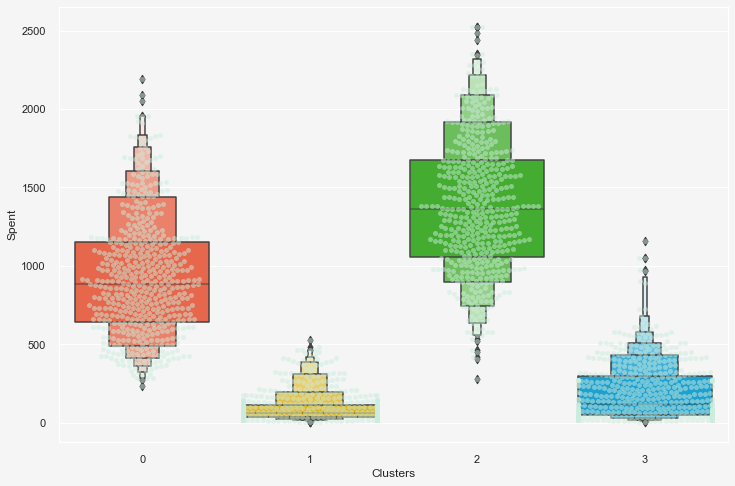

In [95]:
plt.figure(figsize=(12, 8))
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette= pallets)
plt.show()

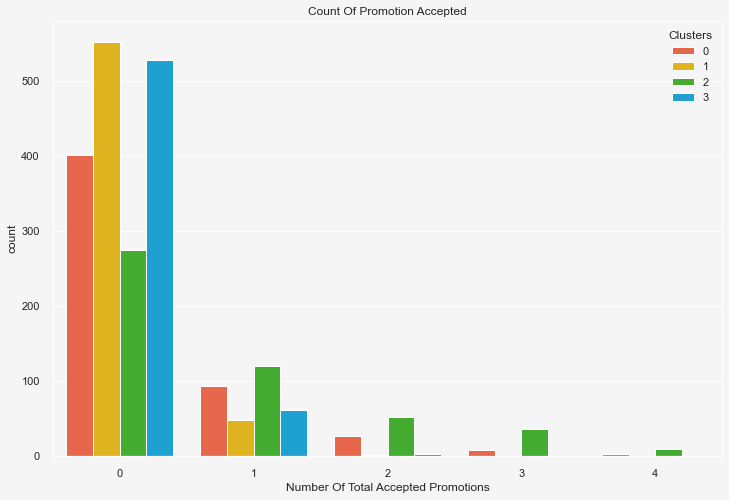

In [96]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure(figsize=(12, 8))
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pallets)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

No ha habido una respuesta abrumadora a las campañas hasta ahora. Muy pocos participantes en general. Además, nadie toma parte en los 5 de ellos. Quizás se requieren campañas mejor dirigidas y bien planificadas para impulsar las ventas.

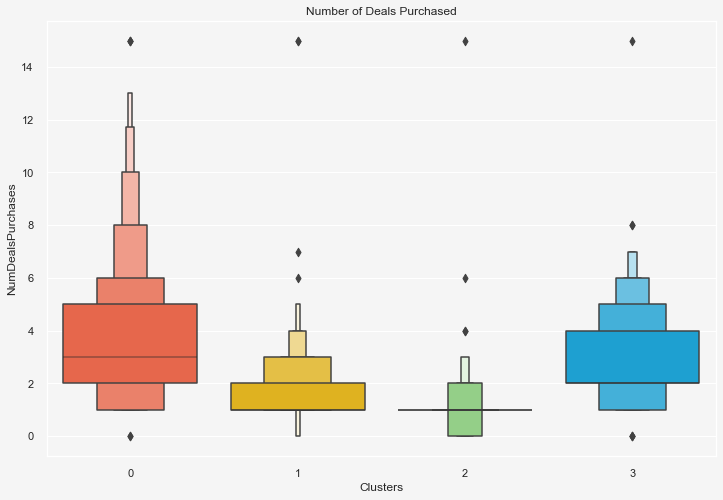

In [97]:
#Plotting the number of deals purchased
plt.figure(figsize=(12, 8))
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pallets)
pl.set_title("Number of Deals Purchased")
plt.show()

A diferencia de las campañas, las ofertas ofrecidas funcionaron bien. Tiene el mejor resultado con el grupo 0 y el grupo 3. Sin embargo, nuestro grupo de clientes estrella 1 no está muy interesado en las ofertas. Nada parece atraer abrumadoramente al grupo 2

### Profiling

Ahora que hemos formado los grupos y mirado sus hábitos de compra. Veamos quiénes están todos allí en estos grupos. Para eso, perfilaremos los clusters formados y llegaremos a una conclusión sobre quién es nuestro cliente estrella y quién necesita más atención por parte del equipo de marketing de la tienda minorista.

Decidir que trazaré algunas de las características que son indicativas de los rasgos personales del cliente a la luz del grupo en el que se encuentran. Sobre la base de los resultados, llegaré a las conclusiones.

<Figure size 432x288 with 0 Axes>

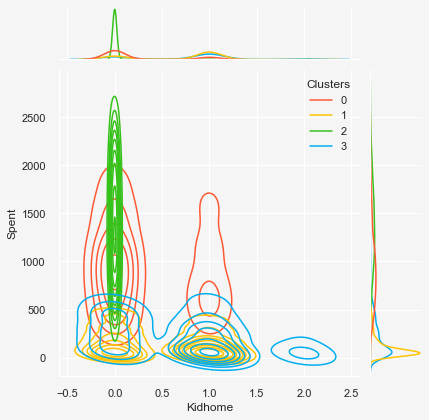

<Figure size 432x288 with 0 Axes>

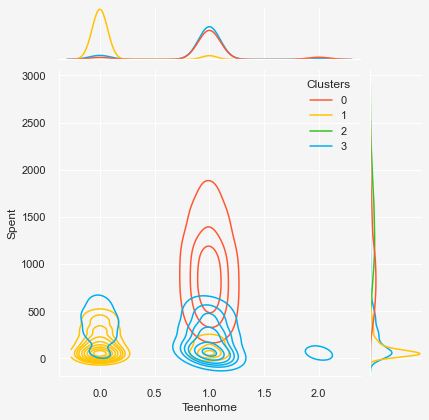

<Figure size 432x288 with 0 Axes>

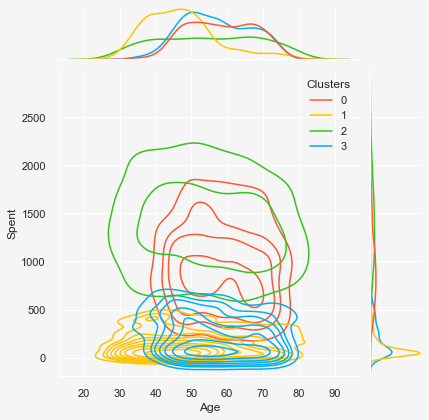

<Figure size 432x288 with 0 Axes>

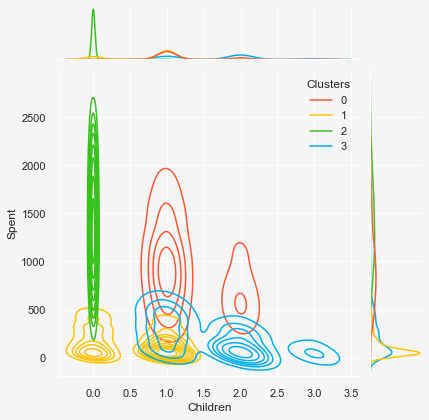

<Figure size 432x288 with 0 Axes>

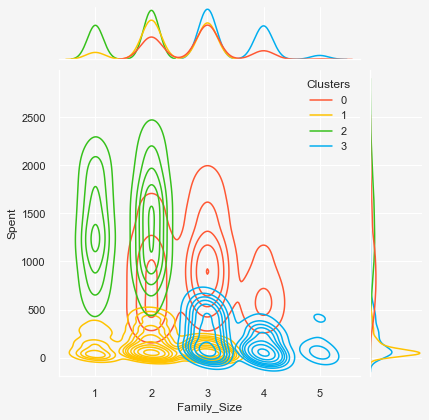

<Figure size 432x288 with 0 Axes>

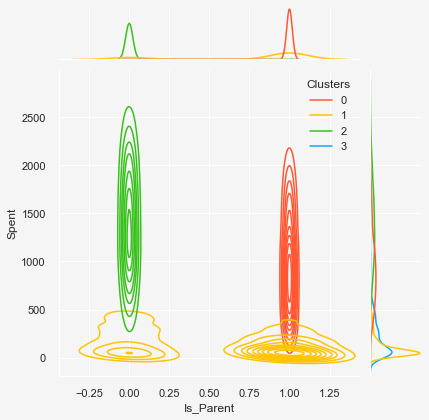

<Figure size 432x288 with 0 Axes>

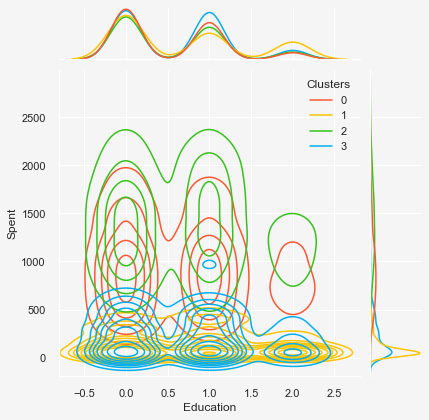

<Figure size 432x288 with 0 Axes>

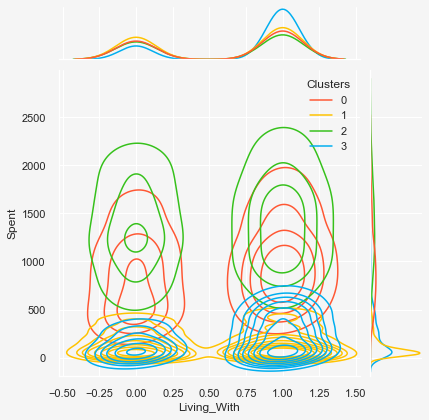

In [99]:
Personal = [ "Kidhome","Teenhome", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue =df["Clusters"], kind="kde", palette=pallets)
    plt.show()

https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering/notebook

### Results:

#### Cluster 0:
* Son definitivamente padres
* Maximo hay 4 y minimo 2 miembros en la familia.
* Padres solteros son un subset de este grupo.
* La mayoria tienen jovenes en casa
* Relativamente viejos.


#### Cluster 1:
* No son padres
* Maximo 2 miembros en la familia
* A sligth majority of couples over single people
* Span all ages
* A high income group

#### Cluster 2:

* Mayoria son padres
* Maximo 3 miembros en la familia
* La mayoria tiene niños pequeños 
* Relativamente jovenes

#### Cluster 3:
* Son padres
* 5 miembros en la familia y minimo 2
* Tienen hijos jovenes
* Relativamente viejos
* Grupo de bajo ingreso